In [3]:
import glob
import os
from haven import haven_utils as hu
import numpy as np
from skimage.segmentation import  find_boundaries, new_watershed,watershed
import matplotlib.pyplot as plt
import skimage.io as sio

from skimage.segmentation import find_boundaries
from skimage.filters import gaussian, sobel, scharr, difference_of_gaussians
from skimage import color
import json


In [26]:
SMOOTH = 1e-6

edge_filter = sobel

data_dir = "./CoNSeP"

mode = "Train"

In [27]:
def validate_obj_params(obj_params=dict()):
    if not type(obj_params) is dict:
        raise TypeError('The obj_params is expected to be a dictionary not a {}'.format(type(obj_params)))
    if not 'sigma' in obj_params.keys():
        obj_params['sigma'] = 0.0
    if not 'alpha' in obj_params.keys():
        obj_params['alpha'] = 1.0
    return obj_params

In [28]:
def generate_dist(image, points, obj_params=dict()):
    obj_params = validate_obj_params(obj_params)
    points = np.array(points)
    pl = np.zeros(image.shape[:2])
    if len(points)!=0:
        pl[points[0,:].round().astype(int), points[1, :].round().astype(int)] = np.arange(1, len(points[0]) + 1)
        image = gaussian(image, 2.1381697911810127,multichannel=True)  
        
        region = np.zeros(image.shape[:2])
        for index in range(len(points[0])):
            x = points[0][index].round().astype(int)
            y = points[1][index].round().astype(int)
            for i in range(region.shape[0]):
                for j in range(region.shape[1]):
                    if(np.sqrt((x-i)**2+(y-j)**2)<=3):
                        region[i][j] = 1

        # return watershed(image[:,:,2], pl)
        reg_split,dist = new_watershed(image,pl,method=True)
        return reg_split,dist ,region
    else:
        return np.zeros(image.shape[:2]), np.inf*np.ones(image.shape[:2])

In [29]:
def generate_obj(image, points, obj_params=dict()):
    obj_params = validate_obj_params(obj_params)
    reg_split,dist,region = generate_dist(image, points, obj_params)    
    bkg = find_boundaries(reg_split)
    dist[bkg] = np.inf
    # return np.exp(-obj_params['alpha'] * dist ** 2), bkg, reg_split
    return np.exp(-obj_params['alpha'] * dist ** 2), bkg, region

In [30]:
def generate_obj_from_file(img_file, points_file, obj_params=dict()):
    obj_params = validate_obj_params(obj_params)
    img = sio.imread(img_file)[:,:,0:3]
    points = hu.load_json(points_file)
    if type(points) is dict:
        dist = np.stack([generate_obj(img, v, obj_params) for _, v in points.items()], axis=0)
        return dist
    elif type(points) is list:
        print("It's a List")
    else:
        print("Type Error:")

    return generate_obj(img, points, obj_params=obj_params)

In [31]:
def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.round().astype(bool)
    labels = labels.round().astype(bool)
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    return iou

In [32]:
def cross_entropy_numpy(outputs: np.array, labels: np.array):
    return np.mean(-labels * np.log(SMOOTH + outputs) - (1 - labels) * np.log(SMOOTH + 1 - outputs))

In [33]:
# for train_pts in glob.glob(os.path.join(data_dir, "Train", "Pts", "*")):
test_image = "/data114_1/wzy/dataset/CoNSeP/Train/dealing/train_10_0_0.png"
test_points = "/data114_1/wzy/dataset/CoNSeP/Train/Points/train_10_0_0.json"
obj = generate_obj_from_file(test_image, test_points)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
obj_dir = os.path.join(data_dir,mode,'Objs')
os.makedirs(obj_dir, exist_ok=True)

bkg_dir = os.path.join(data_dir,mode,'Bkgs')
os.makedirs(bkg_dir, exist_ok=True)

img_dir = os.path.join(data_dir,mode,'Images')
os.makedirs(img_dir, exist_ok=True)

gt_dir = os.path.join(data_dir,mode,'GTs')

os.makedirs(gt_dir, exist_ok=True)

region_dir = os.path.join(data_dir,mode,'Regions')
os.makedirs(region_dir, exist_ok=True)

annotion_dir = os.path.join(data_dir,mode,'Pts')
os.makedirs(annotion_dir, exist_ok=True)

src_root = os.path.join("/data114_1/wzy/dataset/CoNSeP",mode)

In [ ]:
file_paths = os.listdir(os.path.join(src_root,"Points"))
file_paths.sort()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_0_0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_0_248


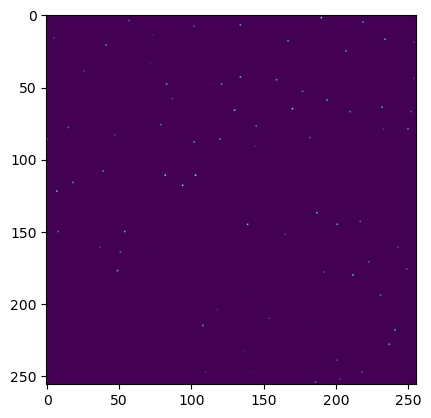

In [ ]:
for i,file_path in enumerate(file_paths):
    file_name = file_path.split('.')[0]
    print(file_name)
    img_path = os.path.join(src_root,"dealing",file_name+".png")
    ann_path = os.path.join(src_root,"Points",file_path)
    result = generate_obj_from_file(img_path,ann_path)[0]
    obj = result[0]
    bkg = result[1]
    region = result[2]

    new_region = np.zeros((obj.shape[0],obj.shape[1]))
    gt=np.load(os.path.join(src_root,"dealing",file_name+"_inst.npy"))
    sio.imsave(os.path.join(img_dir,file_name+'.png'),sio.imread(img_path))
    sio.imsave(os.path.join(obj_dir,file_name+'.png'),obj)
    sio.imsave(os.path.join(bkg_dir,file_name+'.png'),bkg.astype('uint8'))
    sio.imsave(os.path.join(region_dir,file_name+'.png'),region.astype('uint8'))
    sio.imsave(os.path.join(gt_dir,file_name+'.png'),gt.astype('uint8'))

    annotion = hu.load_json(ann_path)
    with open(os.path.join(annotion_dir,file_path), "w") as json_file:
            json.dump(annotion, json_file, indent=4, sort_keys=True)
    

In [2]:
from src.datasets import HEDataset,ConsepDataset,ConsepDataset_Fast
import albumentations as A
import random
data_transform = A.Compose([A.Flip(p=0.3),
                            A.Affine(p=0.3),
                            A.Rotate(p=0.3),
                            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                            A.GaussianBlur(3, p=0.3),
                            A.GaussNoise(30, p=0.3)],
                            
                            keypoint_params=A.KeypointParams(format='yx'),
                            additional_targets={'mask0': 'mask',
                                                'mask1': 'mask',
                                                'mask2': 'mask'})

/home/wzy/.conda/envs/general/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module '_watershed_cy' does not match runtime version 3.7
  return f(*args, **kwds)
/home/wzy/.conda/envs/general/lib/python3.7/site-packages/albumentations/augmentations/blur/transforms.py:185: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


(array([0., 1.], dtype=float32), array([65458,    78]))


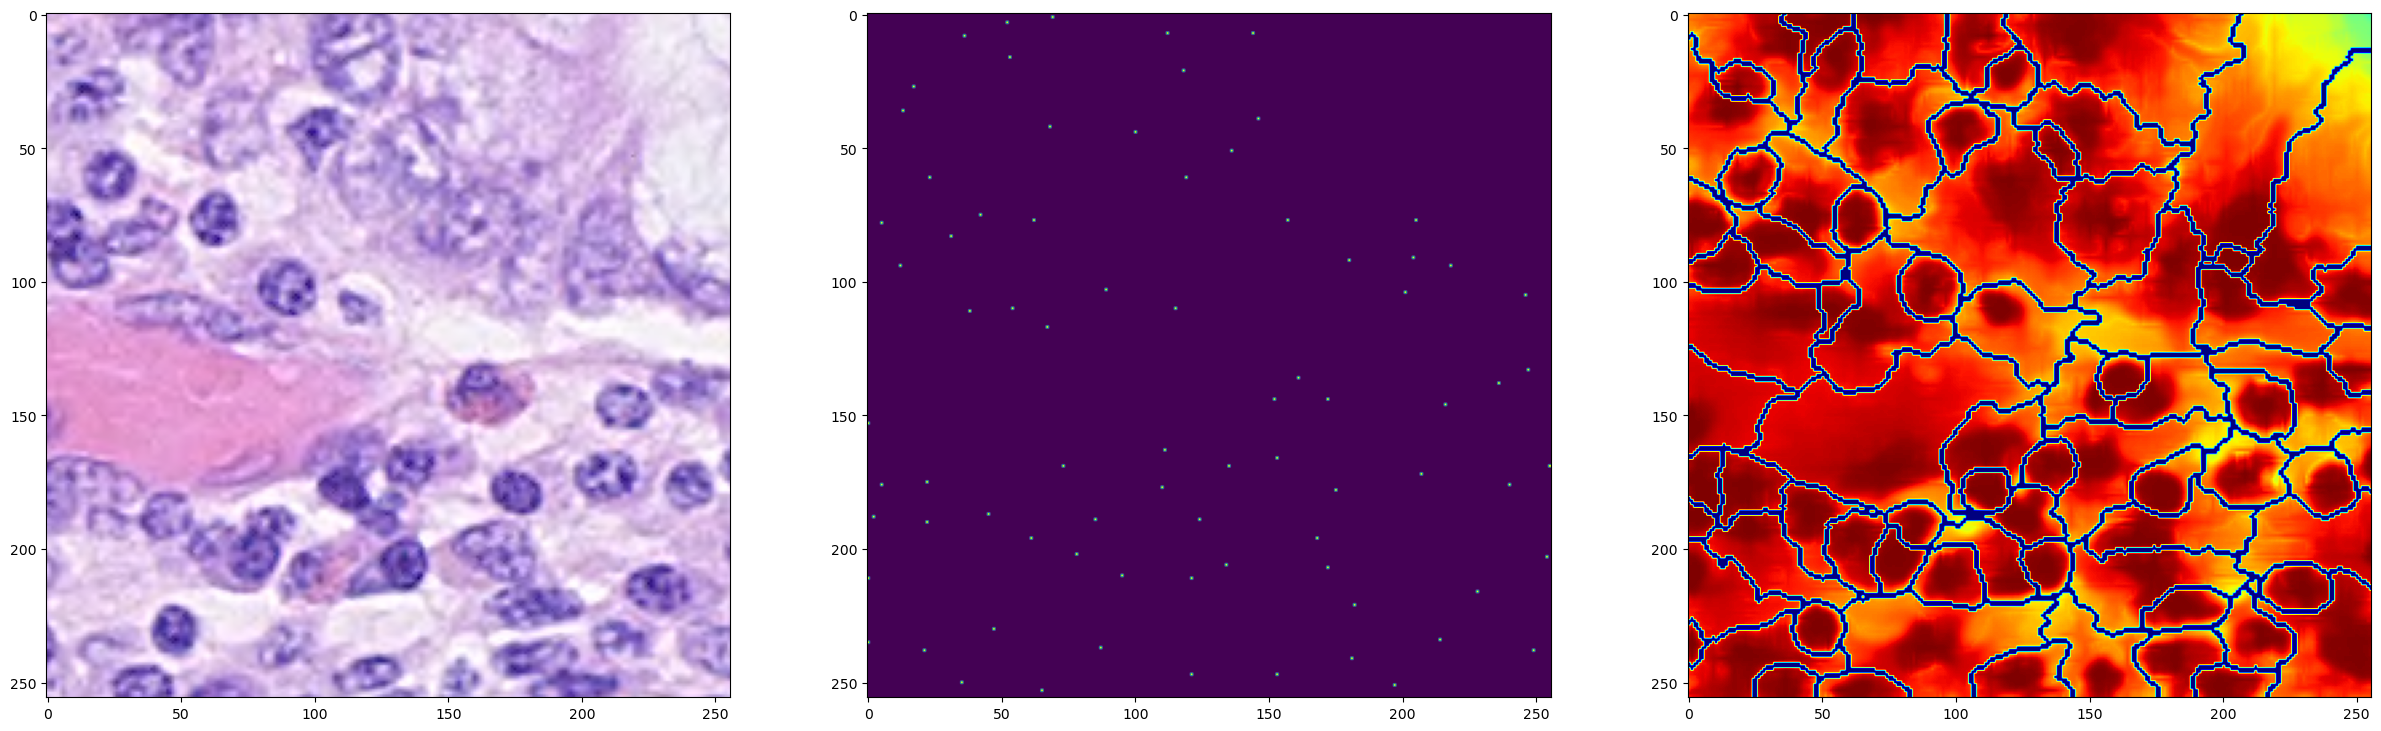

In [15]:
MoNuSegdisplay_set = ConsepDataset(data_dir = './CoNSeP',transform=data_transform,option = 'Train')
MoNu_0 = MoNuSegdisplay_set[1]
fig,axes = plt.subplots(1,3, figsize=(30,10))

axes[0].imshow(MoNu_0["images"].numpy().transpose(1,2,0)) 
axes[1].imshow(MoNu_0["points"].numpy())
axes[2].imshow(MoNu_0["obj"].numpy(),cmap='jet')


obj = MoNu_0["points"].numpy()
# print(obj.mean())
print(np.unique(obj,return_index=False,return_counts=True,return_inverse=False))

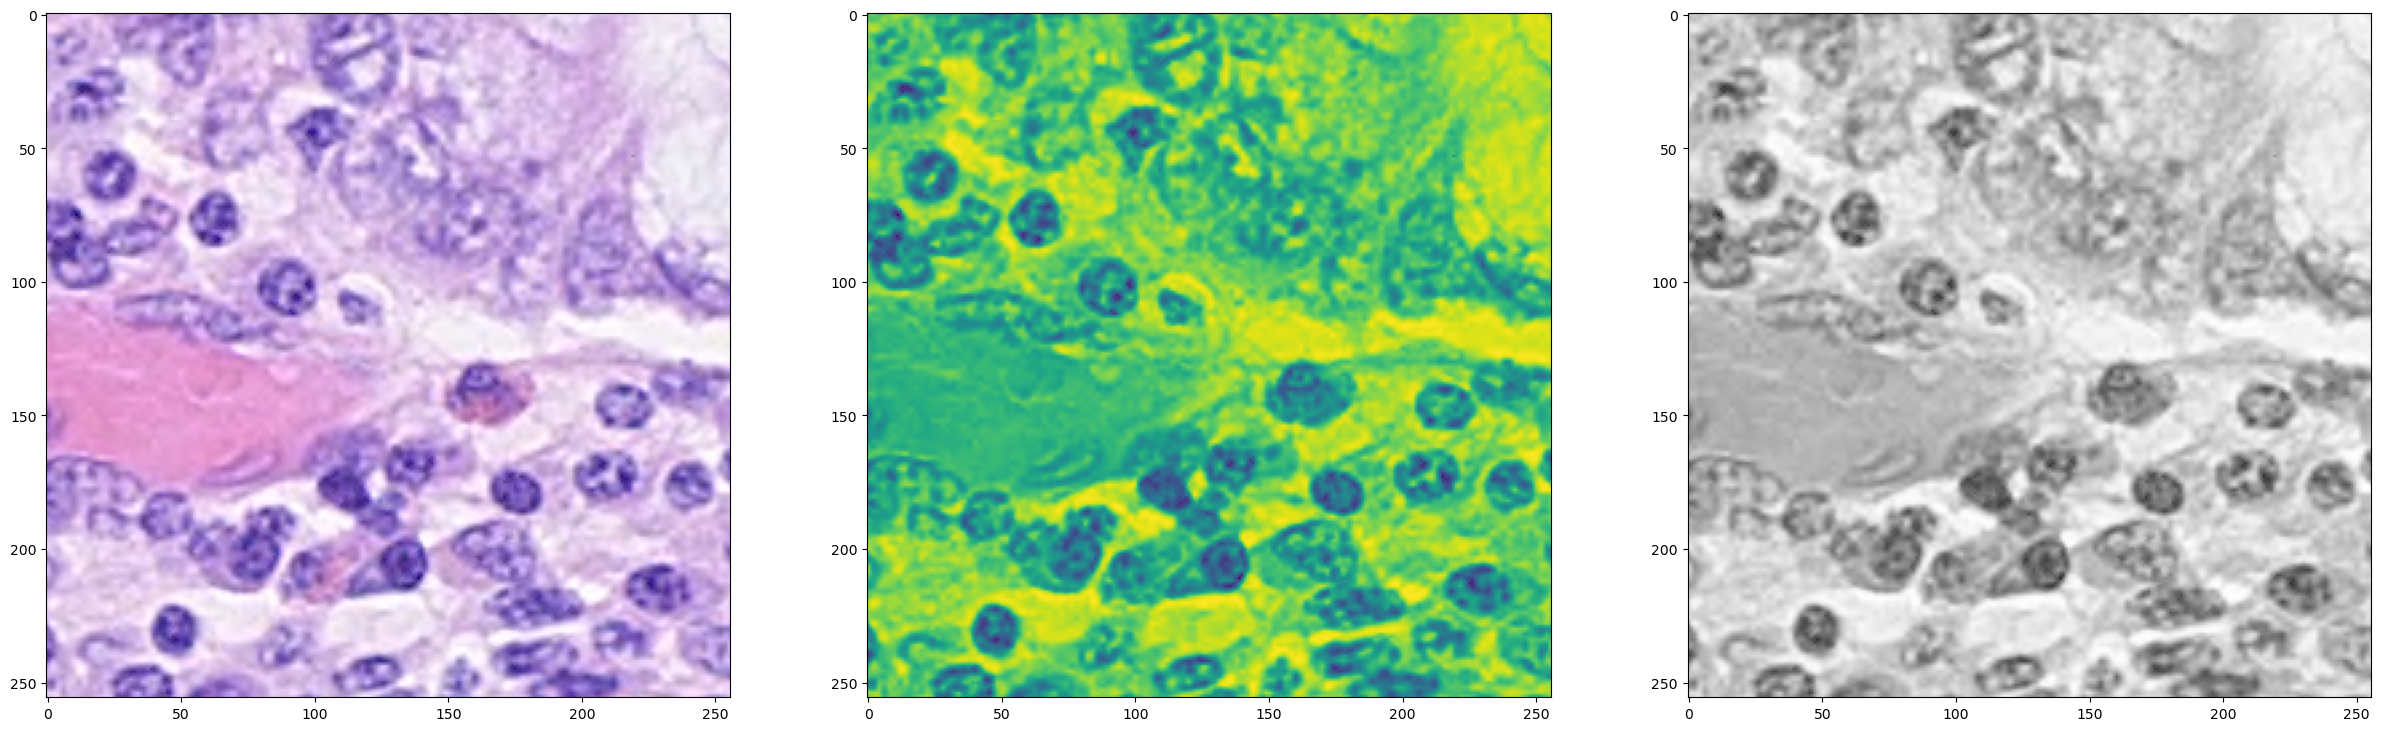

In [23]:
import cv2
image = MoNu_0["images"].numpy().transpose(1,2,0)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
recover = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

fig,axes = plt.subplots(1,3, figsize=(30,10))
axes[0].imshow(image)
axes[1].imshow(gray)
axes[2].imshow(recover)

In [24]:
image==recover

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,